# Social Media Text Analytics

In [1]:
#################################################
# Package imports
#################################################
%matplotlib inline

from __future__ import division
import math
import re
import urllib
import numpy as np
import csv
import pandas as pd
import string
import collections
from collections import Counter
import sys
import datetime
from dateutil.parser import parse
from string import punctuation
import matplotlib.pyplot as plt
import nltk
from nltk.tag import pos_tag
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords, subjectivity
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
from wordcloud import WordCloud, STOPWORDS
import unicodedata
reload(sys)
sys.setdefaultencoding("utf-8")

In [2]:
#global variables
TITLE_SIZE = 20
plt.style.use('ggplot')

# Preprocess Data

In [3]:
##################################################################
#Parse the statuses and returns the list of words for each text
##################################################################

#Remove URLs if any
def removeURLs (text):
	return re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)

#Remove all illegal characters, convert to lower case, stopwords
def filterWords(text):
	text = removeURLs(text)
	#Create the stop words list
	stopwords_en = nltk.corpus.stopwords.words('english')
	stopwords_en = map(lambda w: w, stopwords_en)
	#Split the words by spaces
	words = text.split(" ")
	words = filter(lambda word: not word.isdigit(), words)
	words = filter(lambda word: not word.startswith('http'),words)
	words = filter(lambda word: not word.startswith('@'),words)
	words = filter(lambda word: not word.startswith('RT'),words)

	RemoveWords = string.punctuation
	for item in RemoveWords:
		words = [word.replace(item,'') for word in words]
	words = filter(lambda word: word != '', words)

	words = [word.lower() for word in words]
	words = filter(lambda word: not word in stopwords_en, words)
    
	NoiseWords = ['uchicago','illinois', 'chicago','northwesternu','universities', 'stanford', 'princeton',
                  'university','school','veep','thrones','northwestern', 'United States']
	for item in NoiseWords:
		words = [word.replace(item,'') for word in words]
        
	words = ' '.join(words)
	return words

#Remove URLs if any
def strip_proppers_POS(text):
	tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
	non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
	return non_propernouns

#Standardize location names when possible
def cleanLocations(loc):
	if loc == "Chicago":
		loc = "Chicago, IL"
	elif loc == "Chicago, Illinois":
		loc = "Chicago, IL"
	elif loc == "Chicago, IL 60637":
		loc = "Chicago, IL"
	elif loc == "Hyde Park, Chicago":
		loc = "Chicago, IL"
	elif loc == "New York":
		loc = "New York, NY"
	elif loc == "USA":
		loc = "United States"              
	return loc

In [4]:
#read tab separated file
df = pd.DataFrame.from_csv('twitter.txt', sep='\t')
#name columns
df.columns = ['LANG','DATE','USER_ID','USER_NAME','LOCATION','TWEET']
df = df.dropna()
df.head(2)

,LANG,DATE,USER_ID,USER_NAME,LOCATION,TWEET
662821090176143360,,,,,,
6.653135e+17,en,Fri Nov 13 23:41:06 +0000 2015,sass1h,Sashay,"Small Town, USA",RT @sofiaorden: Linguistics (audio) - The Univ...
6.657929e+17,en,Sun Nov 15 07:26:22 +0000 2015,williamwtowns,William W Towns,"Chicago, IL",RT @DNAinfoCHI: UPDATE: CPS and @Uchicago offi...


In [5]:
#unicode friendly
df['TWEET'] = df['TWEET'].apply(str)
#save original tweet
df['TEXT'] = df['TWEET']
#indicate retweets
df['RETWEET'] = df['TWEET'].apply(lambda tweet: 'RT @' in tweet)
#clean up
df['TWEET'] = df['TWEET'].apply(lambda tweet: filterWords(tweet))
df['LOCATION'] = df['LOCATION'].apply(lambda loc: cleanLocations(loc))

#order tweets by time
df = df[df.LANG == 'en']
df = df.ix[pd.to_datetime(df.DATE).order().index]
df.index = df['DATE']
df.head(2)

,LANG,DATE,USER_ID,USER_NAME,LOCATION,TWEET,TEXT,RETWEET
DATE,,,,,,,,
Tue Oct 06 21:37:17 +0000 2015,en,Tue Oct 06 21:37:17 +0000 2015,jenniferjun,Jennifer Jun,"Chicago, IL",council nonres sr fellow introducing dr yang y...,.@ChicagoCouncil Nonres Sr Fellow @Dali_Yang i...,False
Tue Oct 06 21:37:29 +0000 2015,en,Tue Oct 06 21:37:29 +0000 2015,EdeleMark,Mark Edele,Western Australia,congratulations fellow alumni amp oscar sanche...,Congratulations to fellow @UChicago alumni @Al...,False


# Prolific Tweeters

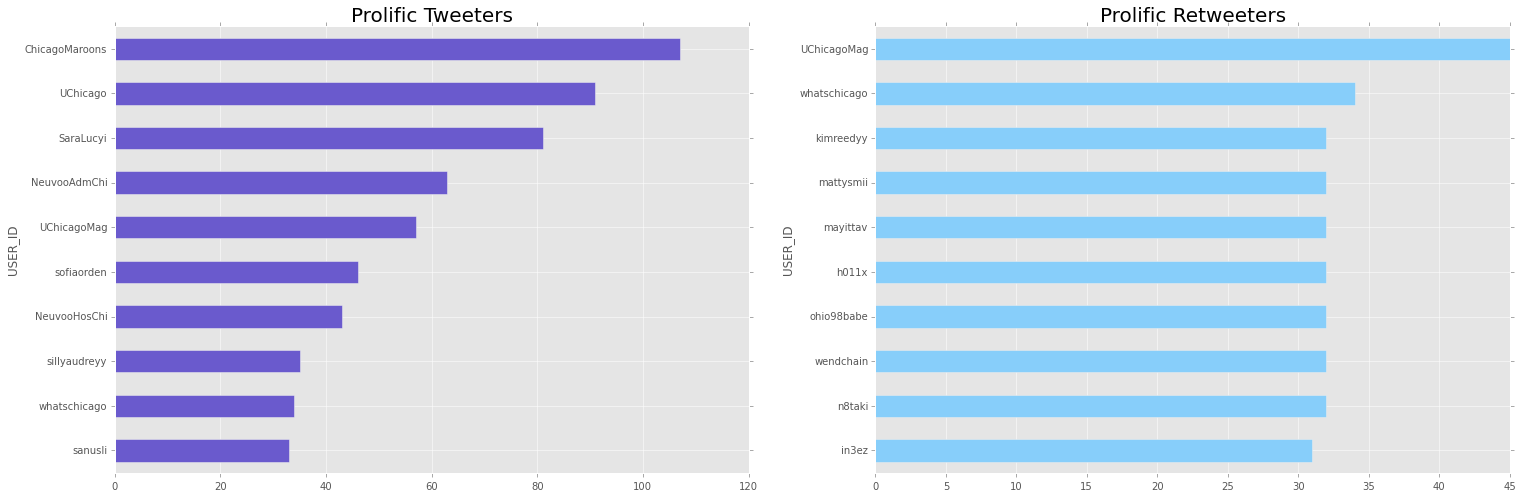

In [6]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
ax1.set_title("Prolific Tweeters" , fontsize = TITLE_SIZE)
dfx = df.groupby('USER_ID').size()
dfx.sort(ascending=[0])
dfx = dfx.tail(10)
dfx.plot(kind='barh', ax=ax1, color = 'slateblue')

ax2.set_title("Prolific Retweeters" , fontsize = TITLE_SIZE)
dfx = df.groupby('USER_ID').apply(lambda x: sum(x['RETWEET']))
dfx.sort(ascending=[0])
dfx = dfx.tail(10)
dfx.plot(kind='barh', ax=ax2, color = 'lightskyblue')
plt.show()

# Separate Tweets   

In [7]:
df = df[df['RETWEET'] == False]

In [8]:
df.head(2)

,LANG,DATE,USER_ID,USER_NAME,LOCATION,TWEET,TEXT,RETWEET
DATE,,,,,,,,
Tue Oct 06 21:37:17 +0000 2015,en,Tue Oct 06 21:37:17 +0000 2015,jenniferjun,Jennifer Jun,"Chicago, IL",council nonres sr fellow introducing dr yang y...,.@ChicagoCouncil Nonres Sr Fellow @Dali_Yang i...,False
Tue Oct 06 21:37:29 +0000 2015,en,Tue Oct 06 21:37:29 +0000 2015,EdeleMark,Mark Edele,Western Australia,congratulations fellow alumni amp oscar sanche...,Congratulations to fellow @UChicago alumni @Al...,False


# Sentiment Analysis

In [9]:
##################################################################
# plots sentiment analysis
##################################################################
def plot_polarity(df_in,color,alpha):
    df_roll = pd.rolling_mean(df_in, 5)
    ax = df_roll.plot(kind='area', legend = True, color = color, figsize = (25, 8), alpha=alpha)
    ax.set_xlim((0, 110))
    ax.set_xlabel("Date")
    ax.set_ylabel("Sentiment Score")
    ax.set_title("Sentiments over time - Positive, Negative, Neutral ", fontsize = TITLE_SIZE)
    locs, labels_text = plt.xticks()
    plt.setp(labels_text, rotation=20)   

## `Vader Sentiment Analysis`

In [10]:
# calculate Vadaer Sentiment scores - positive, negative and neutral
sid = SentimentIntensityAnalyzer()
scale = 2
def sentiment_vader (tweet):
    ss = sid.polarity_scores(tweet)
    return ss['pos']*scale, ss['neg']*scale, ss['neu']  

df['P_POS'] = df['TEXT'].apply(lambda tweet: sentiment_vader(tweet)[0])
df['P_NEG'] = df['TEXT'].apply(lambda tweet: sentiment_vader(tweet)[1])
df['P_NEU'] = df['TEXT'].apply(lambda tweet: sentiment_vader(tweet)[2])

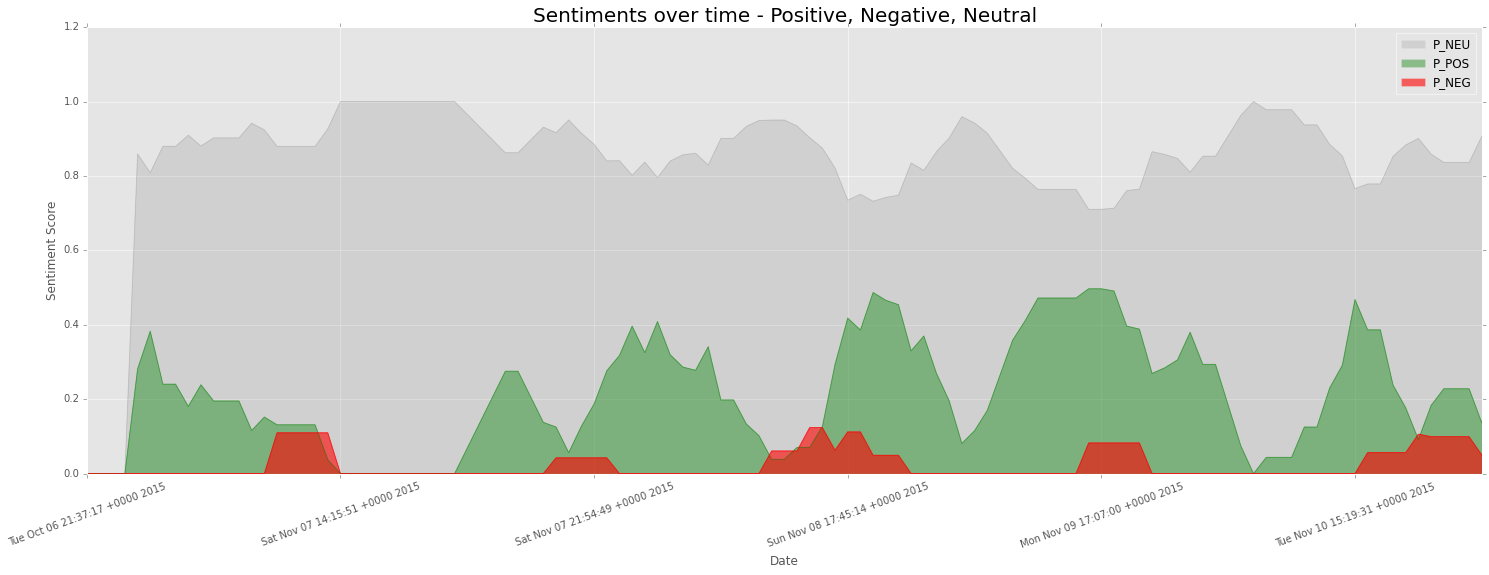

In [11]:
plot_polarity(df['P_NEU'], 'grey', 0.2)
plot_polarity(df['P_POS'], 'green', 0.4)
plot_polarity(df['P_NEG'], 'red', 0.6)

## High Sentiment Tweets

In [12]:
TOP = 20

## `Positive`

In [13]:
df.sort(['P_POS'], ascending=[False])['TEXT'].head(TOP).unique()

array([ 'Awesome photo, thanks for sharing! Enjoy the show! #WSUChicago https://t.co/cy0glFkhQl',
       'UChicago wins best college mail???? https://t.co/f6Q19mAad0',
       'Happy Monday UChicago!',
       '@PhotonicDog woo! Good luck! My top schools were uChicago and Columbia',
       'Great show @UChicago by @harikondabolu - thanks, I really needed a good laugh this week! https://t.co/Jc5kR3J2sv',
       'Congratulations to Jonathan Weare @UChicago for winning @ima_umn prize https://t.co/h84g78eU2l',
       "I love uchicago's mail https://t.co/1IuNZarA6x",
       'Super mums! Happy Friday! #plants of #uchicago https://t.co/wBKxftTXQB',
       'Happy Monday, #UChicago! https://t.co/os67EmYJ5g',
       'Congratulations University of Chicago Medicine. Winner, best healthcare content. #ehealthcareawards #hcic2015 https://t.co/0iY9q8hlQ2',
       'University of Chicago sending me mail hahaha what a good joke',
       'Feeling intellectual #UChicago #harperlibrary https://t.co/dTiSi8iyMH

## `Negative`

In [14]:
df.sort(['P_NEG'], ascending=[False])['TEXT'].head(TOP).unique()

array([ "@NorseMythNews @UChicago  Oh it's no problem ... it's no problem at all.",
       'Hear @haroldpollack of @uchicago crime lab on "Preventing Gun Violence" this Thurs @BrownSchool: https://t.co/biYLJxLnyq #stl #WUSTL',
       'I wanna go to UChicago so bad',
       'Having people call you an angry Black bitch for threatening to hold a protest during #Scav at #UChicago #BlackOnCampus',
       '@JoshMBlackman Unfair to UChicago grads.',
       '@uchicagonews 20 mice dead, live rat found in dead cooler, hotplate behavioral experiments not approved @UChicago https://t.co/FbvnfNWx7o \xe2\x80\xa6',
       'UChicago\'s sexual assault "protocol" was exposed as a sham that for years inherently placed the blame on victims. https://t.co/nvhThxJSfu',
       '20 mice dead, live rat found in dead animal cooler, hotplate behavioral experiments not approved by IACUC @UChicago https://t.co/FbvnfNWx7o',
       "How didn't I hear about @IssaRae coming to @UChicago??!! In Mandel Hall! Sad sad sad 

## Sentiment Polarity Charts

In [15]:
def get_color (pos,neg):
    if pos > neg:
        return 'green'
    else: 
        return 'red'

def plot_polairity_groups(group_id, group_name, count = 10):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
    ax.set_title( (group_name + " sentiments") , fontsize = TITLE_SIZE)
    dfg = pd.DataFrame()
    grp = df.groupby(group_id)
    dfg["P_POS"] = grp.apply(lambda x: x['P_POS'].mean())
    dfg["P_NEG"] = grp.apply(lambda x: x['P_NEG'].mean())
    dfg["C"] = grp.apply(lambda x: get_color(x['P_POS'].mean(),x['P_NEG'].mean()))
    dfg["TWEETS"] = grp.size()
    dfg.reset_index()
    dfg = dfg.sort(['TWEETS']).tail(count)
    dfg.plot(ax = ax, kind='scatter', x='P_POS', y='P_NEG', s=dfg['TWEETS']*50, c=dfg['C'],alpha=0.4);
    labels = dfg.index
    for label, x, y in zip(labels, dfg['P_POS'], dfg['P_NEG']):
        plt.annotate(
            label, 
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.8),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.show()    

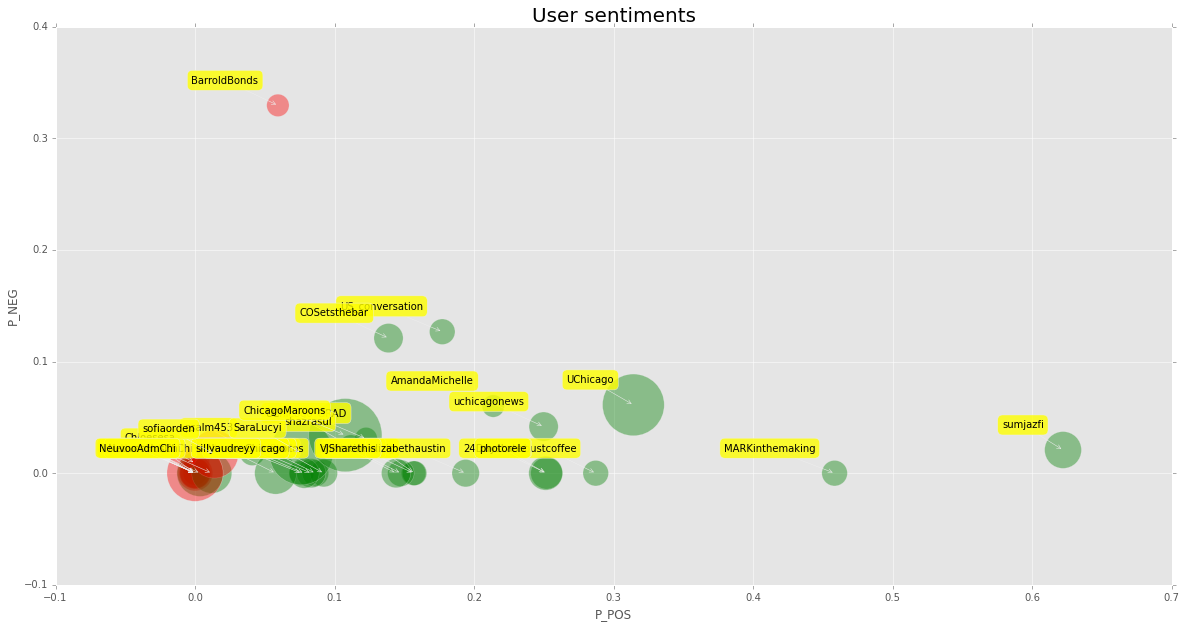

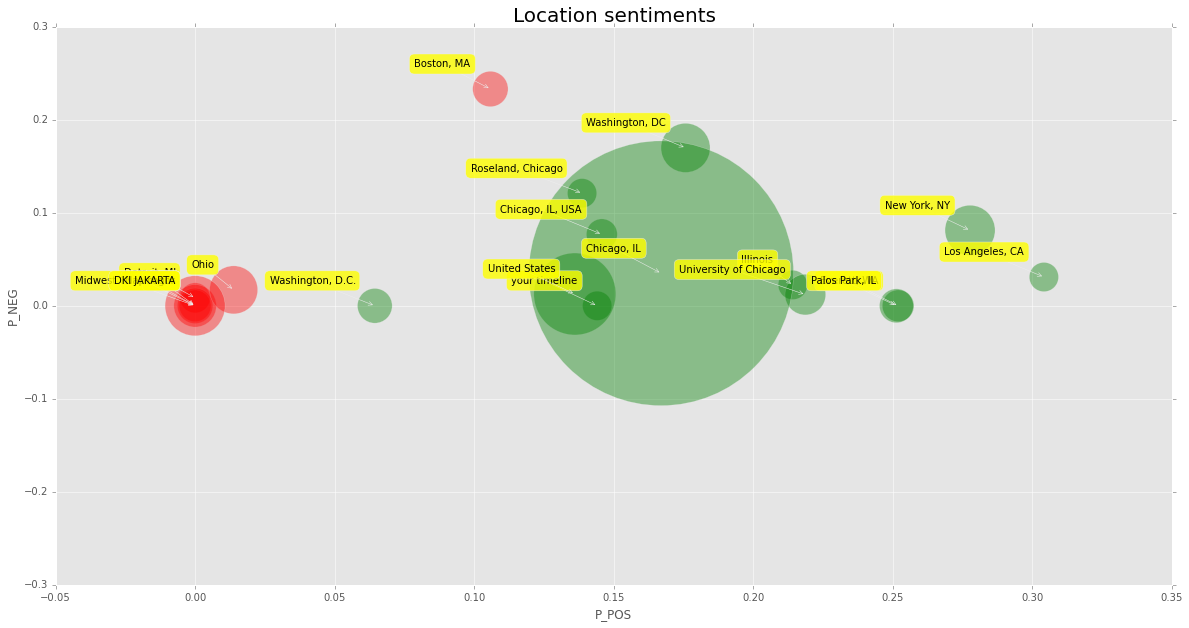

In [16]:
plot_polairity_groups('USER_ID', 'User', 40)
plot_polairity_groups('LOCATION', 'Location', 20)

# Wordcloud

In [17]:
all_words = ' '.join(df['TWEET'].tolist())
tokens = nltk.word_tokenize(all_words)
len(all_words)

224518

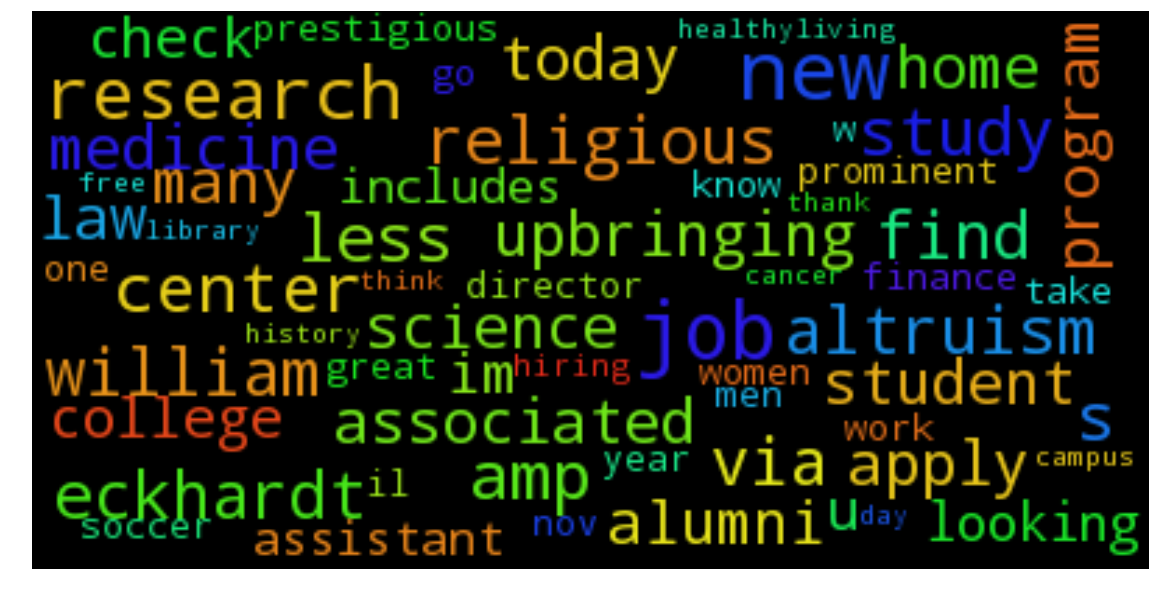

In [18]:
# Generate a word cloud image
# take relative word frequencies into account, lower max_font_size
# wordcloud = WordCloud(max_font_size=40, relative_scaling=.8).generate(all_words)
wordcloud = WordCloud(background_color="black", max_font_size=30, max_words=60,relative_scaling=.4)
wordcloud.generate(all_words)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('tweets.png', bbox_inches='tight')
plt.show()

# Cluster Analysis

In [26]:
NUM_CLUSTERS = 5

In [27]:
########################################################
#Cluster Tweets using K-Means on Tf-Idf coordinates
########################################################

def process_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text)
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens
 
def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=process_text,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.5,
                                 min_df=0.03,
                                 lowercase=True,ngram_range=(1,3))
    
    tfidf_model = vectorizer.fit_transform(texts)
    print vectorizer.get_feature_names()
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(tfidf_model)
 
    clusters = {}
    for idx, label in enumerate(km_model.labels_):
        clusters[idx]= label
 
    return clusters

In [28]:
clusters = cluster_texts(df['TWEET'].tolist(),NUM_CLUSTERS)

In [29]:
df['CLUSTER'] = clusters.values()

In [30]:
df.head(2)

,LANG,DATE,USER_ID,USER_NAME,LOCATION,TWEET,TEXT,RETWEET,P_POS,P_NEG,P_NEU,CLUSTER
DATE,,,,,,,,,,,,
Tue Oct 06 21:37:17 +0000 2015,en,Tue Oct 06 21:37:17 +0000 2015,jenniferjun,Jennifer Jun,"Chicago, IL",council nonres sr fellow introducing dr yang y...,.@ChicagoCouncil Nonres Sr Fellow @Dali_Yang i...,False,0.000,0,1.000,0
Tue Oct 06 21:37:29 +0000 2015,en,Tue Oct 06 21:37:29 +0000 2015,EdeleMark,Mark Edele,Western Australia,congratulations fellow alumni amp oscar sanche...,Congratulations to fellow @UChicago alumni @Al...,False,0.712,0,0.644,1


In [31]:
def plot_clusters(group_id, group_name, count = 10):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
    ax.set_title( ("Topic Clusters") , fontsize = TITLE_SIZE)
    dfg = pd.DataFrame()
    grp = df.groupby(group_id)
    dfg["P_POS_AVG"] = grp.apply(lambda x: x['P_POS'].mean())
    dfg["P_NEG_AVG"] = grp.apply(lambda x: x['P_NEG'].mean())
    dfg["C"] = grp.apply(lambda x: get_color(x['P_POS'].mean(),x['P_NEG'].mean()))
    dfg["TWEETS"] = grp.size()
    dfg["USERS"] = grp.apply(lambda x: set(x['USER_ID']))
    dfg.reset_index()
    dfg = dfg.sort(['TWEETS']).tail(count)
    dfg.plot(ax = ax, kind='scatter', x='P_POS_AVG', y='P_NEG_AVG', s=dfg['TWEETS']*10, c=dfg['C'],alpha=0.4);
    labels = dfg.index
    for label, x, y in zip(labels, dfg['P_POS_AVG'], dfg['P_NEG_AVG']):
        plt.annotate(
            label, 
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.6),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.show()
    return dfg

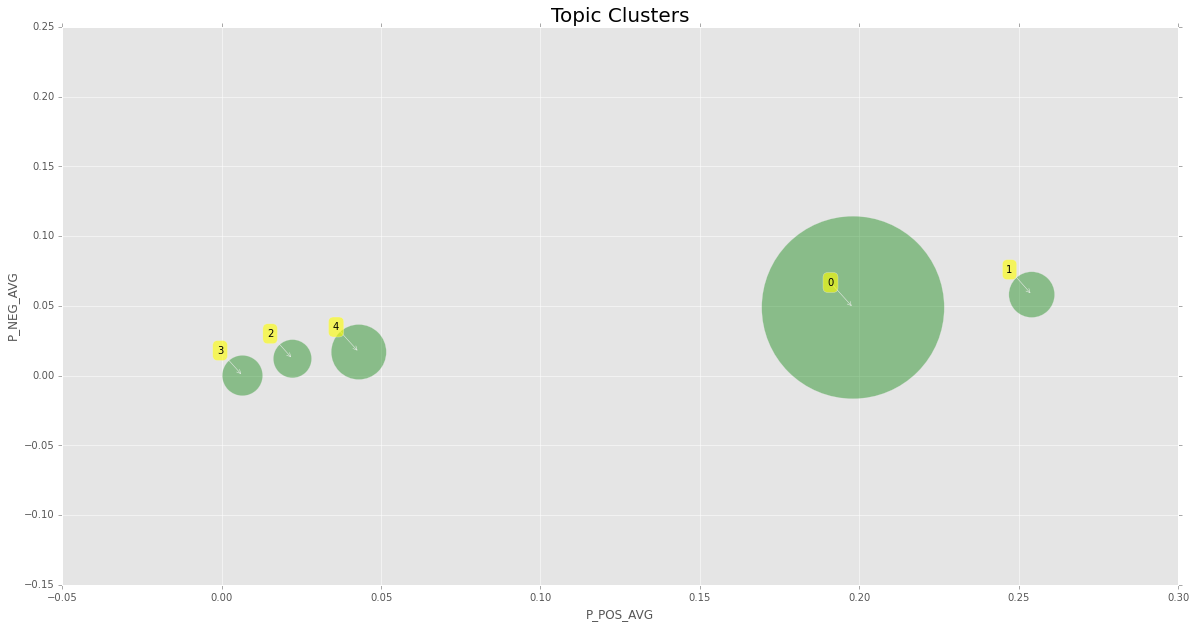

,P_POS_AVG,P_NEG_AVG,C,TWEETS,USERS
CLUSTER,,,,,
2,0.022247,0.012055,green,146,"set([VJSharethis, 1nutclough, blakgsus1, yaren..."
3,0.006564,0.000000,green,163,"set([ayukomkom, hermawan_sopyan, budikusuma_bu..."
1,0.254096,0.058019,green,209,"set([JimTiffinJr, ThisIsIllinois, pndblog, Car..."
4,0.043050,0.016865,green,303,"set([adamvgordon, UChiUrbanLabs, NeuvooLogChi,..."
0,0.198043,0.048789,green,3332,"set([johnkimms, nwi, irvnXX, UChiEnergy, WVON1..."


In [32]:
plot_clusters('CLUSTER', 'Cluster')